In [116]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [117]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128  # stride
BATCH_SIZE = 128  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.001  # lr
PROJ_DIM = 128  # embedding dimension

In [118]:
datapath = "../../../data/MobiFall_Dataset/" 

In [119]:
adl_activities = ['STD', 'WAL', 'JOG', 'JUM', 
                  'STU', 'STN', 'SCH', 'CSI', 'CSO'] 
fall_activities = ['FOL', 'FKL', 'BSC', 'SDL'] 

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

In [120]:
adl_fall_subjects = list(range(1, 12))
print("ADL+Fall subjects:", adl_fall_subjects)

fall_only_subjects = list(range(12, 22)) + list(range(29, 32))
print("Fall-only subjects:", fall_only_subjects)

train_split = adl_fall_subjects[:8] + fall_only_subjects[:9]    
val_split = adl_fall_subjects[8:10] + fall_only_subjects[9:11]    
test_split = adl_fall_subjects[10:] + fall_only_subjects[11:]   

print(f"Train subjects (ADL+Fall): {adl_fall_subjects[:8]}")
print(f"Train subjects (Fall only): {fall_only_subjects[:9]}")
print(f"Total train subjects: {train_split}\n")

print(f"Val subjects (ADL+Fall): {adl_fall_subjects[8:10]}")
print(f"Val subjects (Fall only): {fall_only_subjects[9:11]}")
print(f"Total val subjects: {val_split}\n")

print(f"Test subjects (ADL+Fall): {adl_fall_subjects[10:]}")
print(f"Test subjects (Fall only): {fall_only_subjects[11:]}")
print(f"Total test subjects: {test_split}\n")

print(f"Total number of train subjects: {len(train_split)}")
print(f"Total number of validation subjects: {len(val_split)}")
print(f"Total number of test subjects: {len(test_split)}")

ADL+Fall subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Fall-only subjects: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31]
Train subjects (ADL+Fall): [1, 2, 3, 4, 5, 6, 7, 8]
Train subjects (Fall only): [12, 13, 14, 15, 16, 17, 18, 19, 20]
Total train subjects: [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Val subjects (ADL+Fall): [9, 10]
Val subjects (Fall only): [21, 29]
Total val subjects: [9, 10, 21, 29]

Test subjects (ADL+Fall): [11]
Test subjects (Fall only): [30, 31]
Total test subjects: [11, 30, 31]

Total number of train subjects: 17
Total number of validation subjects: 4
Total number of test subjects: 3


In [121]:
def read_sensor_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
        data_start = 0
        for i, line in enumerate(lines):
            if line.strip() == '@DATA':  # data tag finding
                data_start = i + 1
                break
        
        ###### parsing part
        data_lines = []
        for line in lines[data_start:]:
            if line.strip():  
                try:
                    values = [float(val.strip()) for val in line.strip().split(',')]
                    data_lines.append(values)
                except ValueError:
                    continue
        
        df = pd.DataFrame(data_lines) 
        df = df.ffill()  # forward fill
        df = df.bfill()  # backward fill
        return df

In [122]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [123]:
'''
    TRAIN DATA PREPARING PART
    ONLY "ADL"
'''

train_data_normal = []  
train_labels_normal = [] 

for subject_id in tqdm(train_split):
    if subject_id >= 12 :  
        # Fall-only -> SKIP at train data
        continue
        
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    adl_dir = os.path.join(subject_dir, "ADL")
        
    for activity in adl_activities : # ONLY ADL (normal first)
        activity_dir = os.path.join(adl_dir, activity)
            
        acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
        acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
        
        for acc_file in acc_files:
            trial_num = acc_file.split('_')[-1]
            gyro_file = os.path.join(activity_dir, 
                                     f"{activity}_gyro_{subject_id}_{trial_num}")
                
            try:
                acc_data = read_sensor_file(acc_file)
                acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                
                gyro_data = read_sensor_file(gyro_file)
                gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                
                merged_data = pd.merge_asof(
                    acc_data.sort_values('timestamp'),
                    gyro_data.sort_values('timestamp'),
                    on='timestamp',
                    direction='nearest',
                    tolerance=1e7
                )
                
                merged_data = merged_data.fillna(0)
                sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                         'gyro_x', 'gyro_y', 'gyro_z']].values
                
                activity_labels = np.full(len(sensor_data), label2id[activity])
                
                windows_data, windows_labels = split_sequences(
                    sensor_data, activity_labels, 
                    WINDOW_LENGTH, STRIDE
                )
                
                if len(windows_data) > 0:
                    train_data_normal.append(windows_data)
                    train_labels_normal.append(windows_labels)
                    
            except : 
                print (error)
                
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.06it/s]

# of windows: 3842
data shape: (3842, 6, 256)
shape: (3842,)
{0: 3842}


In [124]:
'''
    TRAIN DATA PREPARING PART
    ADL + FALL
'''

test_data = []
test_labels = []

for subject_id in tqdm(test_split):
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    
    if subject_id < 12: # ADL
        adl_dir = os.path.join(subject_dir, "ADL")
        if os.path.exists(adl_dir):
            for activity in adl_activities:
                activity_dir = os.path.join(adl_dir, activity)
                if not os.path.exists(activity_dir):
                    continue

                acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
                acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
                
                for acc_file in acc_files:
                    trial_num = acc_file.split('_')[-1]
                    gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                    
                    if not os.path.exists(gyro_file):
                        continue
                        
                    try:
                        acc_data = read_sensor_file(acc_file)
                        acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                        
                        gyro_data = read_sensor_file(gyro_file)
                        gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                        
                        merged_data = pd.merge_asof(
                            acc_data.sort_values('timestamp'),
                            gyro_data.sort_values('timestamp'),
                            on='timestamp',
                            direction='nearest',
                            tolerance=1e7
                        )
                        
                        merged_data = merged_data.fillna(0)
                        sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                                 'gyro_x', 'gyro_y', 'gyro_z']].values
                        
                        activity_labels = np.full(len(sensor_data), label2id[activity])
                        windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                        
                        if len(windows_data) > 0:
                            test_data.append(windows_data)
                            test_labels.append(windows_labels)
                            
                    except : 
                        print("error")
                            
    
    falls_dir = os.path.join(subject_dir, "FALLS") # FALL (all subjects)
    if os.path.exists(falls_dir):
        for activity in fall_activities:
            activity_dir = os.path.join(falls_dir, activity)
            if not os.path.exists(activity_dir):
                continue
                
            acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
            acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
            
            for acc_file in acc_files:
                trial_num = acc_file.split('_')[-1]
                gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                
                if not os.path.exists(gyro_file):
                    continue
                    
                try:
                    acc_data = read_sensor_file(acc_file)
                    acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                    
                    gyro_data = read_sensor_file(gyro_file)
                    gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                    
                    merged_data = pd.merge_asof(
                        acc_data.sort_values('timestamp'),
                        gyro_data.sort_values('timestamp'),
                        on='timestamp',
                        direction='nearest',
                        tolerance=1e7
                    )
                    
                    merged_data = merged_data.fillna(0)
                    sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                             'gyro_x', 'gyro_y', 'gyro_z']].values
                    
                    activity_labels = np.full(len(sensor_data), label2id[activity])
                    windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                    
                    if len(windows_data) > 0:
                        test_data.append(windows_data)
                        test_labels.append(windows_labels)
                        
                except : 
                    print ('error')

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print(f"# of windows: {len(test_data)}")
print(f"data shape: {test_data.shape}")
print(f"shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]

# of windows: 813
data shape: (813, 6, 256)
shape: (813,)
{0: 634, 1: 179}


In [125]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (3842, 6, 3)
train data - gyro shape: (3842, 6, 253)
test data - accel shape: (813, 6, 3)
test data - gyro shape: (813, 6, 253)
# of training batches: 31
# of test batches: 7


------

In [126]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(Encoder, self).__init__()
        self.use_skip = use_skip
        self.num_encoders = num_encoders
        
        for i in range(num_encoders):
            setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat, kernel_size=3, padding='same', activation='relu'))
            setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat, kernel_size=3, padding='same', activation='relu'))
            setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat, kernel_size=3, padding='same', activation='relu'))
    
    def call(self, x, training=False):
        for i in range(self.num_encoders):
            if self.use_skip and i > 0:
                identity = x
            
            x = getattr(self, f'conv1_{i}')(x)
            x = getattr(self, f'maxpool1_{i}')(x)
            x = getattr(self, f'conv2_{i}')(x)
            x = getattr(self, f'maxpool2_{i}')(x)
            x = getattr(self, f'conv3_{i}')(x)
            
            if self.use_skip and i > 0:
                x = x + identity
        
        return tf.reduce_mean(x, axis=1)

#### below : test encoder architecture

test_input = tf.random.normal([2, WINDOW_LENGTH, 3])
encoder = DefaultEncoder(in_feat=3, out_feat=64)
test_output = encoder(test_input)

print (f"input shape: {test_input.shape}")
print (f"output shape: {test_output.shape}")
print ("encoder success!")

input shape: (2, 256, 3)
output shape: (2, 64)
encoder success!


In [127]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = layers.Dense(proj_dim, use_bias=False)
            self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
        self.temperature = tf.Variable(0.1, trainable=True)
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [128]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [129]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

def contrastive_loss(sim_matrix):
    batch_size = tf.shape(sim_matrix)[0]
    
    labels = tf.eye(batch_size)
    
    loss_1 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=1),
        from_logits=False
    )
    
    loss_2 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=0),
        from_logits=False
    )
    
    # Take mean of both directional losses
    total_loss = (loss_1 + loss_2) / 2
    return tf.reduce_mean(total_loss)

In [130]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [131]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [132]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  # 단일 값만 받음
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|██████████████████████████████| 31/31 [00:02<00:00, 11.52it/s]


mean value of loss : 4.5656
best loss achieved : 4.5656


Epoch 2/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 54.63it/s]


mean value of loss : 4.2499
best loss achieved : 4.2499


Epoch 3/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 55.47it/s]


mean value of loss : 4.0104
best loss achieved : 4.0104


Epoch 4/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 82.07it/s]


mean value of loss : 3.8254
best loss achieved : 3.8254


Epoch 5/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 82.15it/s]


mean value of loss : 3.6726
best loss achieved : 3.6726


Epoch 6/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 71.49it/s]


mean value of loss : 3.5471
best loss achieved : 3.5471


Epoch 7/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 83.34it/s]


mean value of loss : 3.5522


Epoch 8/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 81.83it/s]


mean value of loss : 3.3397
best loss achieved : 3.3397


Epoch 9/100: 100%|██████████████████████████████| 31/31 [00:00<00:00, 80.34it/s]


mean value of loss : 3.1906
best loss achieved : 3.1906


Epoch 10/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 75.15it/s]


mean value of loss : 3.2091


Epoch 11/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 67.37it/s]


mean value of loss : 3.1835
best loss achieved : 3.1835


Epoch 12/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 71.11it/s]


mean value of loss : 3.1522
best loss achieved : 3.1522


Epoch 13/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 62.53it/s]


mean value of loss : 3.1322
best loss achieved : 3.1322


Epoch 14/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 69.00it/s]


mean value of loss : 2.9652
best loss achieved : 2.9652


Epoch 15/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 75.98it/s]


mean value of loss : 2.8016
best loss achieved : 2.8016


Epoch 16/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 96.91it/s]


mean value of loss : 2.7269
best loss achieved : 2.7269


Epoch 17/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 110.10it/s]


mean value of loss : 2.7487


Epoch 18/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 89.04it/s]


mean value of loss : 2.6178
best loss achieved : 2.6178


Epoch 19/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 80.15it/s]


mean value of loss : 2.7396


Epoch 20/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 94.83it/s]


mean value of loss : 2.7040


Epoch 21/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 104.60it/s]


mean value of loss : 2.4674
best loss achieved : 2.4674


Epoch 22/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 77.81it/s]


mean value of loss : 2.5584


Epoch 23/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 84.15it/s]


mean value of loss : 2.4521
best loss achieved : 2.4521


Epoch 24/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 101.48it/s]


mean value of loss : 2.8567


Epoch 25/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 112.45it/s]


mean value of loss : 2.6477


Epoch 26/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 112.21it/s]


mean value of loss : 2.4614


Epoch 27/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 94.88it/s]


mean value of loss : 2.5810


Epoch 28/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 85.83it/s]


mean value of loss : 2.3163
best loss achieved : 2.3163


Epoch 29/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 61.82it/s]


mean value of loss : 2.4559


Epoch 30/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 81.20it/s]


mean value of loss : 2.3646


Epoch 31/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 93.40it/s]


mean value of loss : 2.2697
best loss achieved : 2.2697


Epoch 32/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 92.24it/s]


mean value of loss : 2.2262
best loss achieved : 2.2262


Epoch 33/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 99.69it/s]


mean value of loss : 2.4296


Epoch 34/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 100.73it/s]


mean value of loss : 2.3274


Epoch 35/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 103.14it/s]


mean value of loss : 2.3610


Epoch 36/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 80.17it/s]


mean value of loss : 2.2445


Epoch 37/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 74.80it/s]


mean value of loss : 2.3497


Epoch 38/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 67.54it/s]


mean value of loss : 2.2360


Epoch 39/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 91.01it/s]


mean value of loss : 2.2234
best loss achieved : 2.2234


Epoch 40/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 95.52it/s]


mean value of loss : 2.0105
best loss achieved : 2.0105


Epoch 41/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 92.53it/s]


mean value of loss : 2.1704


Epoch 42/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 115.76it/s]


mean value of loss : 2.1573


Epoch 43/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 95.65it/s]


mean value of loss : 2.2012


Epoch 44/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 92.24it/s]


mean value of loss : 1.9905
best loss achieved : 1.9905


Epoch 45/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 94.58it/s]


mean value of loss : 1.9335
best loss achieved : 1.9335


Epoch 46/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 93.02it/s]


mean value of loss : 1.8927
best loss achieved : 1.8927


Epoch 47/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 88.56it/s]


mean value of loss : 1.9206


Epoch 48/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 87.77it/s]


mean value of loss : 2.0028


Epoch 49/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 93.17it/s]


mean value of loss : 2.0536


Epoch 50/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 81.68it/s]


mean value of loss : 2.0888


Epoch 51/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 80.82it/s]


mean value of loss : 1.9459


Epoch 52/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 85.44it/s]


mean value of loss : 1.9720


Epoch 53/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 89.11it/s]


mean value of loss : 1.8493
best loss achieved : 1.8493


Epoch 54/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 85.98it/s]


mean value of loss : 1.7936
best loss achieved : 1.7936


Epoch 55/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 76.31it/s]


mean value of loss : 1.8195


Epoch 56/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 64.99it/s]


mean value of loss : 1.7118
best loss achieved : 1.7118


Epoch 57/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 65.24it/s]


mean value of loss : 1.8011


Epoch 58/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 75.50it/s]


mean value of loss : 1.9946


Epoch 59/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 92.92it/s]


mean value of loss : 1.8901


Epoch 60/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 87.25it/s]


mean value of loss : 1.7105
best loss achieved : 1.7105


Epoch 61/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 63.91it/s]


mean value of loss : 1.7323


Epoch 62/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 79.47it/s]


mean value of loss : 1.8511


Epoch 63/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 68.00it/s]


mean value of loss : 1.7164


Epoch 64/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 60.58it/s]


mean value of loss : 1.7385


Epoch 65/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 58.59it/s]


mean value of loss : 1.7552


Epoch 66/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 88.10it/s]


mean value of loss : 1.5732
best loss achieved : 1.5732


Epoch 67/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 77.34it/s]


mean value of loss : 1.6258


Epoch 68/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 85.90it/s]


mean value of loss : 1.8211


Epoch 69/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 83.91it/s]


mean value of loss : 1.7077


Epoch 70/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 76.75it/s]


mean value of loss : 1.5307
best loss achieved : 1.5307


Epoch 71/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 79.78it/s]


mean value of loss : 1.5865


Epoch 72/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 91.17it/s]


mean value of loss : 1.5228
best loss achieved : 1.5228


Epoch 73/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 83.84it/s]


mean value of loss : 1.6110


Epoch 74/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 84.29it/s]


mean value of loss : 1.4770
best loss achieved : 1.4770


Epoch 75/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 78.25it/s]


mean value of loss : 1.5603


Epoch 76/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 68.25it/s]


mean value of loss : 1.5391


Epoch 77/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 56.80it/s]


mean value of loss : 1.6507


Epoch 78/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 66.72it/s]


mean value of loss : 1.5562


Epoch 79/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 75.57it/s]


mean value of loss : 1.4923


Epoch 80/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 78.84it/s]


mean value of loss : 1.6335


Epoch 81/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 65.93it/s]


mean value of loss : 1.5307


Epoch 82/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 91.43it/s]


mean value of loss : 1.7185


Epoch 83/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 107.60it/s]


mean value of loss : 1.6466


Epoch 84/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 96.99it/s]


mean value of loss : 1.5451


Epoch 85/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 110.74it/s]


mean value of loss : 1.6936


Epoch 86/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 88.50it/s]


mean value of loss : 1.5599


Epoch 87/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 94.70it/s]


mean value of loss : 1.3979
best loss achieved : 1.3979


Epoch 88/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 113.76it/s]


mean value of loss : 1.5776


Epoch 89/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 101.87it/s]


mean value of loss : 1.5384


Epoch 90/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 81.80it/s]


mean value of loss : 1.5285


Epoch 91/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 106.96it/s]


mean value of loss : 1.4491


Epoch 92/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 93.59it/s]


mean value of loss : 1.6257


Epoch 93/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 79.97it/s]


mean value of loss : 1.6592


Epoch 94/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 79.97it/s]


mean value of loss : 1.4664


Epoch 95/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 101.73it/s]


mean value of loss : 1.4937


Epoch 96/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 93.24it/s]


mean value of loss : 1.5004


Epoch 97/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 81.57it/s]


mean value of loss : 1.5562


Epoch 98/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 101.91it/s]


mean value of loss : 1.5026


Epoch 99/100: 100%|█████████████████████████████| 31/31 [00:00<00:00, 90.57it/s]


mean value of loss : 1.5627


Epoch 100/100: 100%|████████████████████████████| 31/31 [00:00<00:00, 79.26it/s]

mean value of loss : 1.4151
END THE LEARNING
final best loss: 1.3979


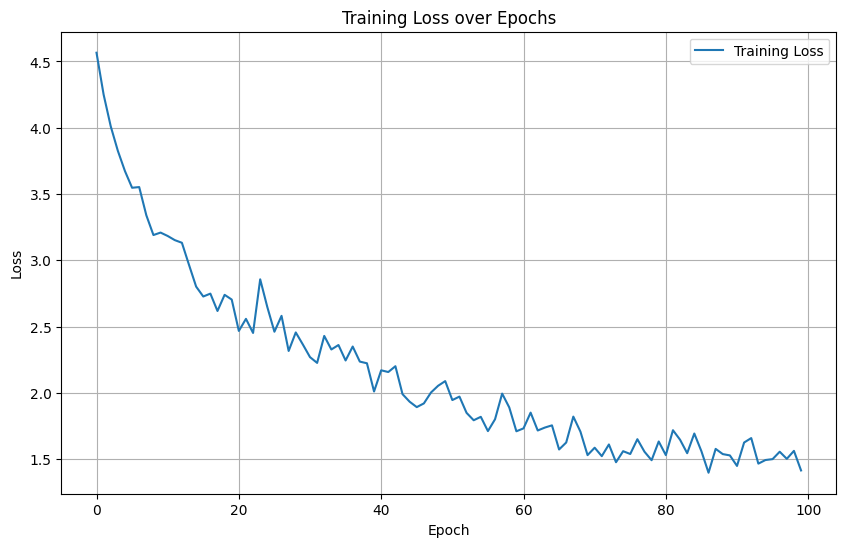

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # Get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        # Compute cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [135]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|████████████████| 7/7 [00:00<00:00, 53.44it/s]


In [136]:
threshold = np.percentile(normal_similarities, 5)

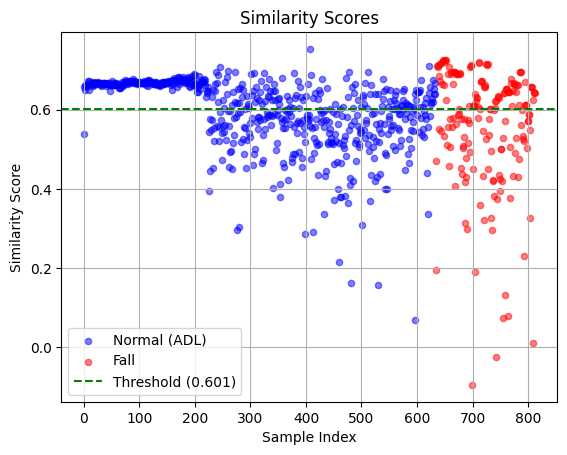

In [137]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [138]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

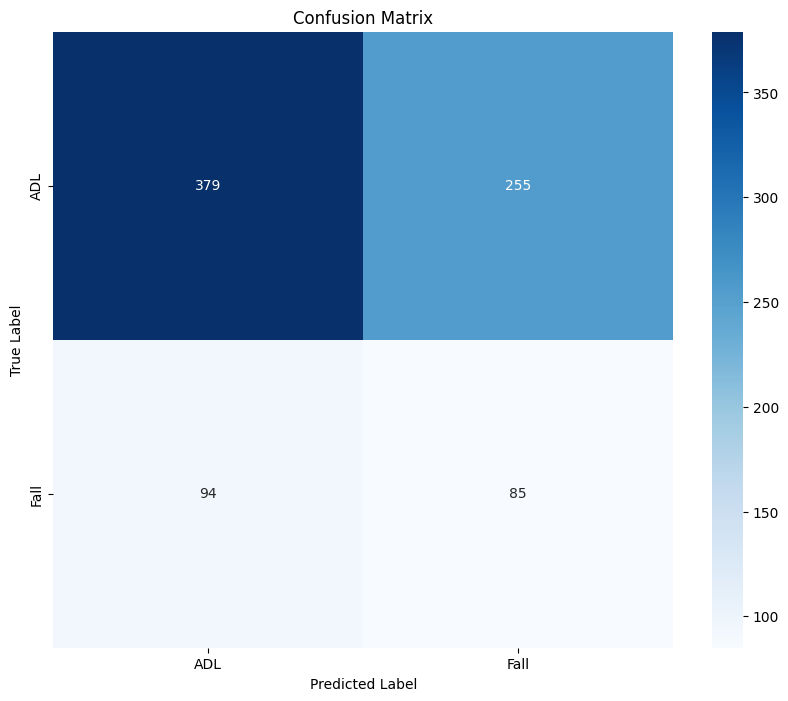

In [139]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [140]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.80      0.60      0.68       634
        Fall       0.25      0.47      0.33       179

    accuracy                           0.57       813
   macro avg       0.53      0.54      0.51       813
weighted avg       0.68      0.57      0.61       813



In [141]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        logits = model(acc_batch, gyro_batch, training=False)
        sim = tf.nn.softmax(logits, axis=-1)
        batch_similarities = tf.reduce_mean(sim, axis=1)
        
        for sim_score, label in zip(batch_similarities.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.0078
  Std: 0.0000
  Min: 0.0078
  Max: 0.0078
ADL ind 1 : 0.0078124995
ADL ind 2 : 0.0078125
ADL ind 3 : 0.007812501
ADL ind 4 : 0.0078125
ADL ind 5 : 0.0078124995
ADL ind 6 : 0.0078124995
ADL ind 7 : 0.0078125
ADL ind 8 : 0.0078125
ADL ind 9 : 0.007812499
ADL ind 10 : 0.007812499
ADL ind 11 : 0.0078125
ADL ind 12 : 0.0078125
ADL ind 13 : 0.0078125
ADL ind 14 : 0.0078124995
ADL ind 15 : 0.0078125
ADL ind 16 : 0.0078124995
ADL ind 17 : 0.0078125
ADL ind 18 : 0.0078125
ADL ind 19 : 0.0078124995
ADL ind 20 : 0.0078125

[ FALL data ]
  Mean: 0.0114
  Std: 0.0063
  Min: 0.0078
  Max: 0.0222
FALL ind 1 : 0.0078124995
FALL ind 2 : 0.007812501
FALL ind 3 : 0.0078124986
FALL ind 4 : 0.0078125
FALL ind 5 : 0.007812499
FALL ind 6 : 0.0078125
FALL ind 7 : 0.0078125
FALL ind 8 : 0.0078125
FALL ind 9 : 0.007812501
FALL ind 10 : 0.0078125
FALL ind 11 : 0.0078125
FALL ind 12 : 0.0078124995
FALL ind 13 : 0.0078125
FALL ind 14 : 0.007812501
FALL ind 15 : 0.007812499
FALL ind 16 :